In [1]:
import pandas as pd
from nltk.corpus import stopwords
import re
import matplotlib.pyplot as plt
import nltk

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')




[nltk_data] Downloading package stopwords to
[nltk_data]     /home/mwarren/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/mwarren/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/mwarren/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [24]:
dfTrain = pd.read_csv("Datasets/Corona_NLP_train.csv", encoding="latin")
dfTest = pd.read_csv("Datasets/Corona_NLP_test.csv", encoding="latin")
print("Number of Train Datapoints: {}".format(dfTrain.shape[0]))
print("Number of Test Datapoints: {}".format(dfTest.shape[0]))
dfTrain.head()

Number of Train Datapoints: 41157
Number of Test Datapoints: 3798


,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [26]:
# Turn sentiment result into numerical values for easy analysis
# Will have to modify this for better model implementation i.e one hot encode
def numerize(result):
    if(result == "Extremely Negative"):
        return -2
    elif result == "Negative":
        return -1
    elif result == "Neutral":
        return 0
    elif result == "Positive":
        return 1
    return 2

dfTrain["Sentiment_Numerical"] = dfTrain.apply(lambda row: numerize(row["Sentiment"]), axis=1)
dfTest["Sentiment_Numerical"] = dfTest.apply(lambda row: numerize(row["Sentiment"]), axis=1)
dfTrain.head()


,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,Sentiment_Numerical
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,0
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive,1
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,1
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive,1
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative,-2


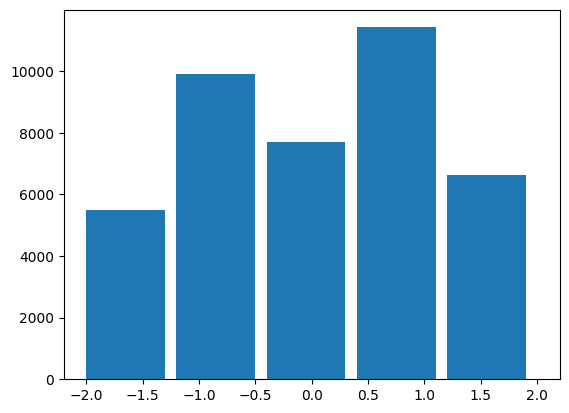

In [27]:
# Analyzing distribution of data
arr = dfTrain["Sentiment_Numerical"].to_numpy()
binNum = 5
# Plot histogram showing the distribution of data
plt.hist(arr, binNum, width=0.7)
plt.show()
# Overall dataset is pretty well distributed, contains slight positive skew

In [30]:
# Data cleaning

# Initialize stop words to be removed
stopWrds = stopwords.words('english')

# Clean text either through stemming or lemmatizing
# Stemming is faster but can lead to two words with different meanings being treated the same
# Lemmatizing may be more accurate but takes longer to train due to higher word count
lemmer = nltk.stem.WordNetLemmatizer()
stemmer = nltk.stem.PorterStemmer()


# Removes all special characters from each word and all words in stop words + removes http links
# Additionally stems or lemmatizes each word to a core definition
def cleanTextStem(text):
    return " ".join([stemmer.stem((re.sub("[^a-z]+", ' ', word.lower()))) for word in text.split() if word not in stopWrds and 'https' not in word])
    
# cleans words but uses a lemmatizer instead of a porter stemmer
def cleanTextLemm(text):
    return " ".join([lemmer.lemmatize((re.sub("[^a-z]+", ' ', word.lower()))) for word in text.split() if word not in stopWrds and 'https' not in word])


def cleanData(df: pd.DataFrame):
    df["Cleaned_Tweets_Stemmed"] = df.apply(lambda row: cleanTextStem(row["OriginalTweet"]), axis=1)
    df["Cleaned_Tweets_Lemmatized"] = df.apply(lambda row: cleanTextLemm(row["OriginalTweet"]), axis=1)

# Clean text and store on dataframe
cleanData(dfTrain)
cleanData(dfTest)

dfTrain.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,Sentiment_Numerical,CleanedTweetsStemmed,CleanedTweetsLemmatized,Cleaned_Tweets_Stemmed,Cleaned_Tweets_Lemmatized
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,0,menyrbi phil gahan chrisitv,menyrbie phil gahan chrisitv,menyrbi phil gahan chrisitv,menyrbie phil gahan chrisitv
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive,1,advic talk neighbour famili exchang phone numb...,advice talk neighbour family exchange phone nu...,advic talk neighbour famili exchang phone numb...,advice talk neighbour family exchange phone nu...
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,1,coronaviru australia woolworth give elderly ...,coronavirus australia woolworth give elderly ...,coronaviru australia woolworth give elderly ...,coronavirus australia woolworth give elderly ...
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive,1,my food stock one empty please panic there ...,my food stock one empty please panic there ...,my food stock one empty please panic there ...,my food stock one empty please panic there ...
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative,-2,me readi go supermarket covid outbreak not...,me ready go supermarket covid outbreak not...,me readi go supermarket covid outbreak not...,me ready go supermarket covid outbreak not...


In [31]:
# Save data frame
#dfTrain.to_csv("Datasets/Corona_NLP_train_cleaned.csv", index=False)
#dfTest.to_csv("Datasets/Corona_NLP_test_cleaned.csv", index=False)

In [32]:
# Prepare data for use with chosen model
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Putting this in a function to easily call it from external files
# Count vectorize = number of occurences of word, tfidf = word frequency
def vectorize(cleanText, useCountVect=True):
    # Vectorize text either using a count vectorizer or tfidf
    vect = CountVectorizer() if useCountVect else TfidfVectorizer()
    return vect.fit_transform(cleanText)


X = vectorize(dfTrain["CleanedTweetsStemmed"].tolist())
print(X.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
